# Heart Disease Prediction

## Objective

In this project, I use the K-Nearest Neighbors (KNN) algorithm to predict whether a person has heart disease based on various health-related features. The dataset comes from Kaggle ("Heart Disease Prediction with Dataquest"), which seems to be a slightly modified version of the original UCI Heart Disease dataset.

I chose KNN as a starting point because it's a simple and widely used algorithm for classification tasks. The goal is to see how well it performs on this dataset and to learn more about how it works in practice. After building the KNN model, I also plan to try other models like logistic regression, decision trees, or support vector machines to compare the results and see which one gives the best performance.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix

In [4]:
heart_test = pd.read_csv('heart_test.csv')
heart_train = pd.read_csv('heart_train.csv')

In [6]:
heart_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,63,M,ATA,139,217,1,ST,128,Y,1.2,Flat,1
1,55,M,ATA,110,214,1,ST,180,N,0.4,Up,0
2,59,F,ASY,130,338,1,ST,130,Y,1.5,Flat,1
3,47,M,ASY,160,0,0,Normal,124,Y,0.0,Flat,1
4,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1


In [8]:
heart_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             184 non-null    int64  
 1   Sex             184 non-null    object 
 2   ChestPainType   184 non-null    object 
 3   RestingBP       184 non-null    int64  
 4   Cholesterol     184 non-null    int64  
 5   FastingBS       184 non-null    int64  
 6   RestingECG      184 non-null    object 
 7   MaxHR           184 non-null    int64  
 8   ExerciseAngina  184 non-null    object 
 9   Oldpeak         184 non-null    float64
 10  ST_Slope        184 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 15.9+ KB


In [10]:
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Sex             734 non-null    object 
 2   ChestPainType   734 non-null    object 
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    int64  
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    object 
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    object 
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    object 
 11  HeartDisease    734 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 68.9+ KB


In [12]:
print(heart_train.duplicated().sum())
print(heart_test.duplicated().sum())

0
0


In [14]:
heart_train.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,53.848774,132.874659,203.227520,0.228883,136.377384,0.865123,0.553134
std,9.440574,18.080330,108.402067,0.420400,25.832297,1.056964,0.497508
min,29.000000,92.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,180.000000,0.000000,119.000000,0.000000,0.000000
50%,55.000000,130.000000,225.000000,0.000000,138.000000,0.500000,1.000000
75%,61.000000,141.000000,269.750000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,5.600000,1.000000


In [16]:
heart_test.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,184.000000,184.000000,184.00000,184.000000,184.000000,184.000000
mean,52.163043,130.489130,181.13587,0.250000,138.532609,0.976087
std,9.304535,20.091319,111.77934,0.434194,23.908501,1.102542
min,28.000000,0.000000,0.00000,0.000000,80.000000,-0.100000
25%,45.750000,120.000000,155.25000,0.000000,121.750000,0.000000
50%,52.000000,130.000000,210.50000,0.000000,139.000000,0.650000
75%,58.000000,140.000000,254.50000,0.250000,155.250000,1.725000
max,75.000000,192.000000,518.00000,1.000000,195.000000,6.200000


The Cholesterol and RestingBP columns contain values of 0, which likely represent missing or invalid data. We should impute these values appropriately.

In [19]:
(heart_test['RestingBP'] == 0).sum()

1

In [21]:
# There is one 0 value in the RestingBP column, and we have excluded it.
heart_test = heart_test[heart_test['RestingBP'] != 0]
(heart_test['RestingBP'] == 0).sum()

0

<Axes: xlabel='HeartDisease', ylabel='count'>

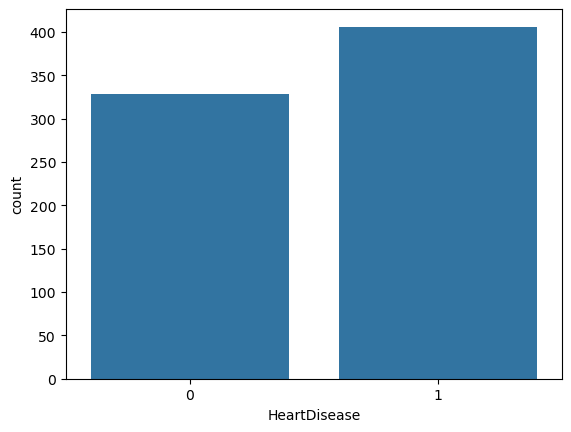

In [23]:
# Check the value counts for the target column
sns.countplot(x ='HeartDisease', data = heart_train)

In [25]:
cat_cols = ['ChestPainType', 'Sex', 'RestingECG', 'ExerciseAngina', 'ST_Slope','FastingBS']
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

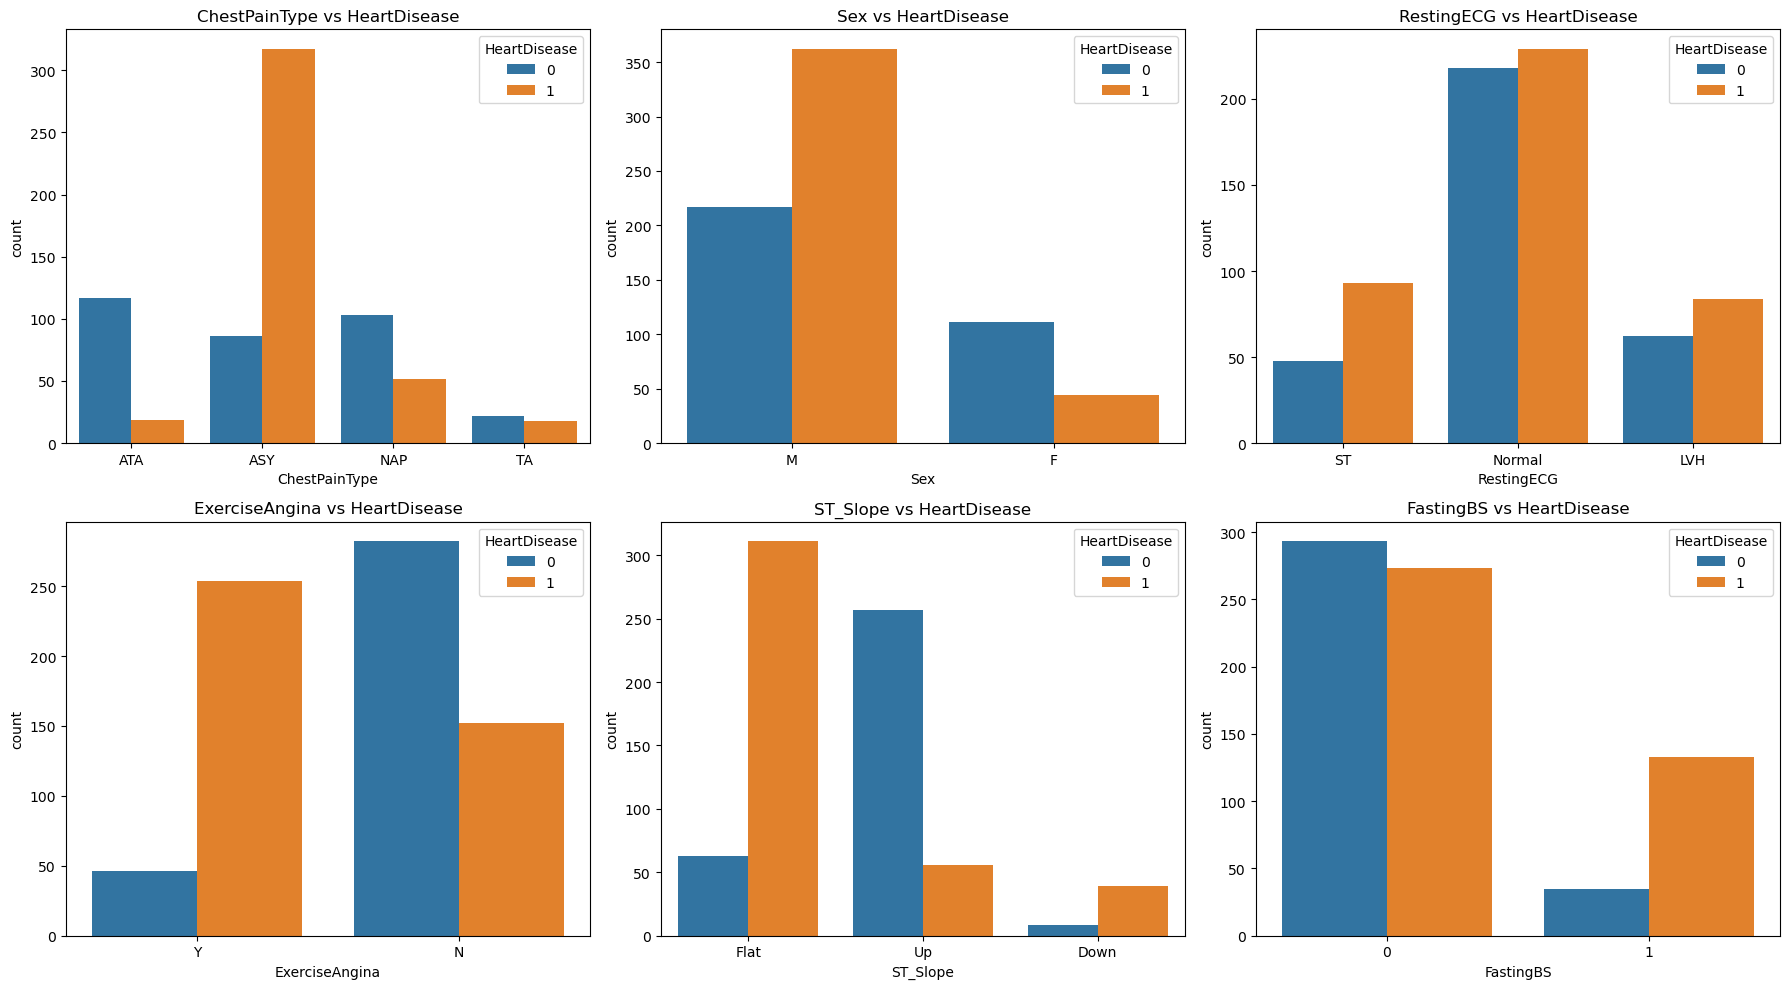

In [27]:
plt.figure(figsize=(18, 10))

for i, col in enumerate(cat_cols):
    plt.subplot(2, 3, i + 1)       
    sns.countplot(x=col, 
                  hue='HeartDisease', 
                  data=heart_train,)
    plt.title(f"{col} vs HeartDisease")

plt.tight_layout()
plt.show()

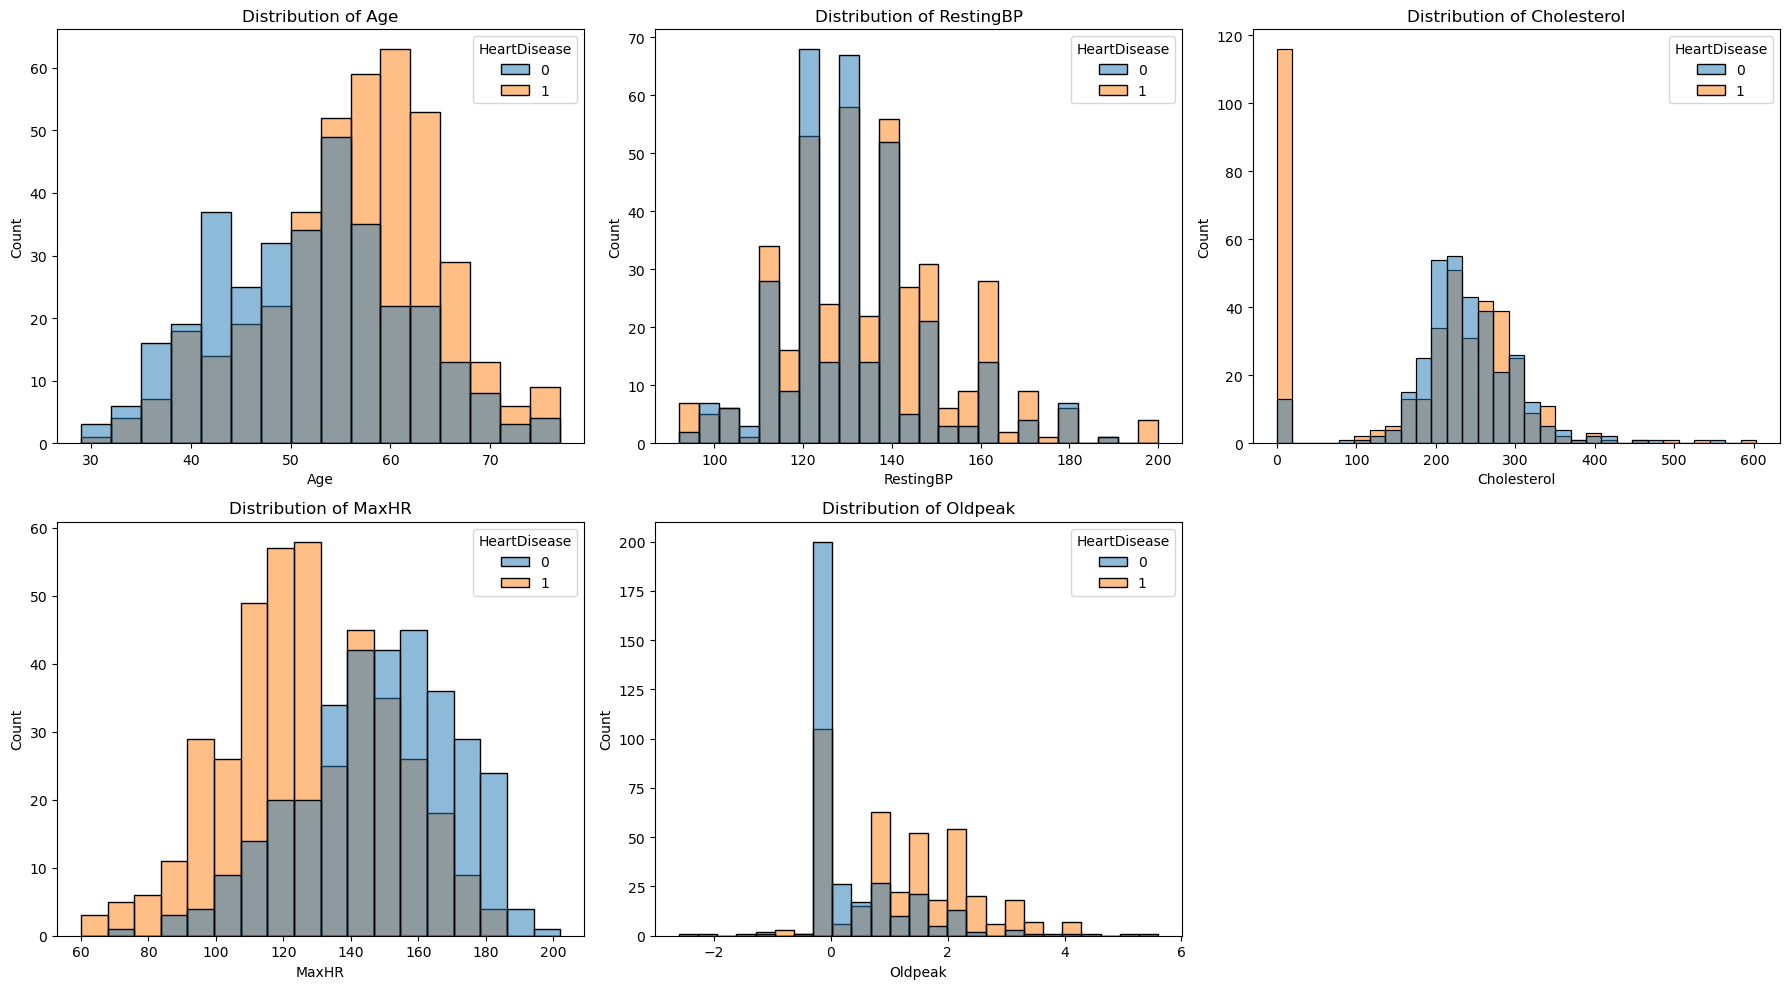

In [28]:
plt.figure(figsize=(18, 10))

# Plotting value counts for each categorical feature
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i + 1)  
    sns.histplot(x=col, hue = 'HeartDisease', data=heart_train)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [30]:
# To treat 0 values as missing data (NaN), we will convert them to NaN values
heart_train["Cholesterol"].replace(0, np.nan, inplace=True)
heart_test ["Cholesterol"].replace(0, np.nan, inplace=True)

In [31]:
X = heart_train.drop('HeartDisease', axis=1)  
y = heart_train['HeartDisease']               


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


# Pipeline for numerical features
num_pipeline = Pipeline([
    ('imputer_', SimpleImputer(strategy="median")),
    ('scaler_', MinMaxScaler())
])
# Pipeline for caterogical features
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

# Create a preprocessor to apply separate cleaning and transformation pipelines to numerical and categorical columns 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ]
)

In [35]:
# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


# Get feature names after transformation
feature_names_out = preprocessor.get_feature_names_out()

# # Convert transformed arrays back to DataFrames to enable correlation analysis.
X_train_processed_df = pd.DataFrame(
    X_train_processed,
    columns=preprocessor.get_feature_names_out(),
    index=X_train.index)

X_test_processed_df = pd.DataFrame(
    X_test_processed, 
    columns=preprocessor.get_feature_names_out(),
    index=X_test.index)

In [37]:
X_train_processed_df.head()

,num__Age,num__RestingBP,num__Cholesterol,num__MaxHR,num__Oldpeak,cat__ChestPainType_ASY,cat__ChestPainType_ATA,cat__ChestPainType_NAP,cat__ChestPainType_TA,cat__Sex_F,...,cat__RestingECG_LVH,cat__RestingECG_Normal,cat__RestingECG_ST,cat__ExerciseAngina_N,cat__ExerciseAngina_Y,cat__ST_Slope_Down,cat__ST_Slope_Flat,cat__ST_Slope_Up,cat__FastingBS_0,cat__FastingBS_1
572,0.250000,0.351852,0.167954,0.546875,0.605263,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6,0.729167,0.481481,0.298263,0.484375,0.473684,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
466,0.500000,0.351852,0.187259,0.687500,0.342105,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
23,0.375000,0.398148,0.314672,0.859375,0.342105,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
695,0.645833,0.398148,0.298263,0.023438,0.407895,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [39]:
# Append y_train to the processed x_train features to analyze feature-target correlations.
X_train_processed_df = X_train_processed_df.copy()
X_train_processed_df['HeartDisease_Target'] = y_train.values

In [41]:
X_train_processed_df.head(2)

,num__Age,num__RestingBP,num__Cholesterol,num__MaxHR,num__Oldpeak,cat__ChestPainType_ASY,cat__ChestPainType_ATA,cat__ChestPainType_NAP,cat__ChestPainType_TA,cat__Sex_F,...,cat__RestingECG_Normal,cat__RestingECG_ST,cat__ExerciseAngina_N,cat__ExerciseAngina_Y,cat__ST_Slope_Down,cat__ST_Slope_Flat,cat__ST_Slope_Up,cat__FastingBS_0,cat__FastingBS_1,HeartDisease_Target
572,0.250000,0.351852,0.167954,0.546875,0.605263,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1
6,0.729167,0.481481,0.298263,0.484375,0.473684,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1


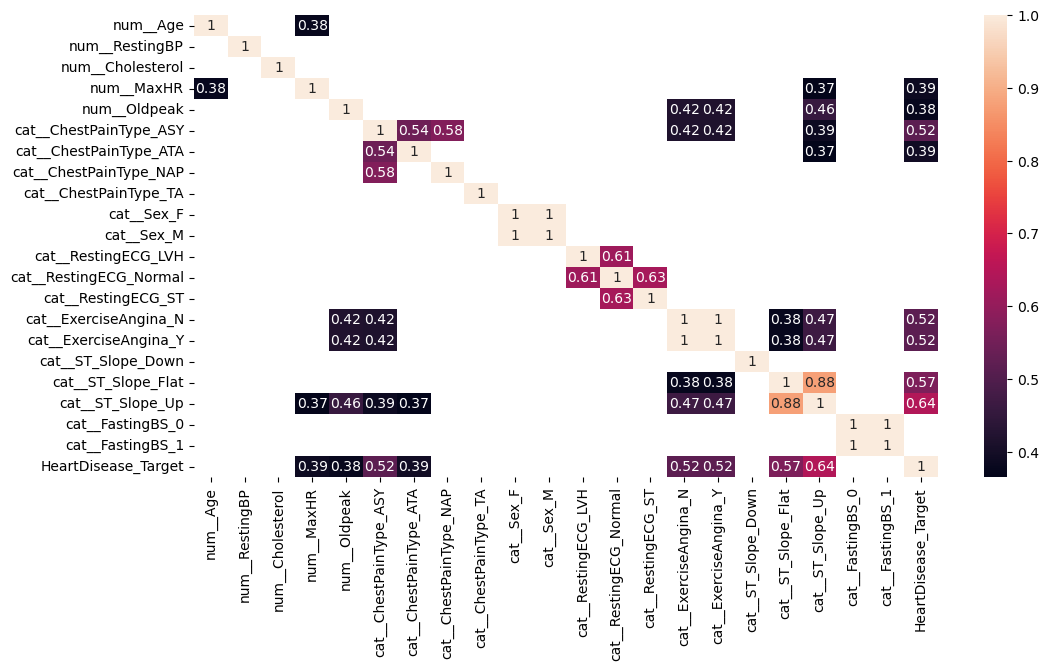

In [43]:
# Whether negative or positive, it makes no difference — I used the absolute values of the correlations.
correlation = abs(X_train_processed_df.corr())

plt.figure(figsize=(12,6))
sns.heatmap(correlation[correlation > 0.35], annot=True)
plt.show()

In [45]:
X_train_processed_df.columns

Index(['num__Age', 'num__RestingBP', 'num__Cholesterol', 'num__MaxHR',
       'num__Oldpeak', 'cat__ChestPainType_ASY', 'cat__ChestPainType_ATA',
       'cat__ChestPainType_NAP', 'cat__ChestPainType_TA', 'cat__Sex_F',
       'cat__Sex_M', 'cat__RestingECG_LVH', 'cat__RestingECG_Normal',
       'cat__RestingECG_ST', 'cat__ExerciseAngina_N', 'cat__ExerciseAngina_Y',
       'cat__ST_Slope_Down', 'cat__ST_Slope_Flat', 'cat__ST_Slope_Up',
       'cat__FastingBS_0', 'cat__FastingBS_1', 'HeartDisease_Target'],
      dtype='object')

In [47]:
# Feature selection based on the correlated values
features = [#'num__Age',
            'num__MaxHR', 
            'num__Oldpeak', 
            #'cat__ChestPainType_ASY',
            #'cat__Sex_M',
            'cat__ST_Slope_Up', 
            #'cat__ExerciseAngina_N',
            #'cat__FastingBS_0'
]
X_train_selected = X_train_processed_df[features]
X_test_selected = X_test_processed_df[features]

In [51]:
# Initialize the model
knn = KNeighborsClassifier(n_neighbors=4)

# Train the model
knn.fit(X_train_selected, y_train)

# Make predictions
y_pred = knn.predict(X_test_selected)

# Evaluate model
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7755

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        66
           1       0.84      0.73      0.78        81

    accuracy                           0.78       147
   macro avg       0.78      0.78      0.78       147
weighted avg       0.79      0.78      0.78       147



<Axes: >

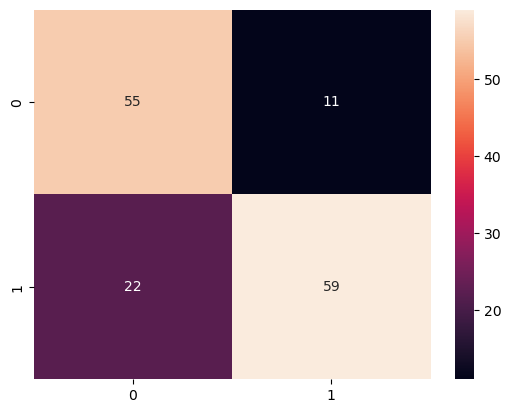

In [53]:
cm= confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [55]:
# Training accuracy tells us how good the model is at predicting the outcomes of the data it already saw during training.
train_pred = knn.predict(X_train_selected)
train_accuracy = accuracy_score(y_train, train_pred)

print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Difference: {train_accuracy - test_accuracy:.4f}")

Training accuracy: 0.8756
Test accuracy: 0.7755
Difference: 0.1001


## Model Interpretation

The model seems a bit cautious when predicting positives but tends to mislabel some negative cases more often. If the goal is to catch more negative cases, this trade-off might be acceptable. Next, I’ll try using GridSearchCV to fine-tune the model and see if we can improve its overall performance.

## Grid Search

In [60]:
param_grid = {
    'n_neighbors': np.arange(1, 15),      
    'metric': ['manhattan','minkowski'],
    }

knn_2 = KNeighborsClassifier()
grid = GridSearchCV(estimator = knn_2, param_grid = param_grid, cv=5)
grid.fit(X_train_selected, y_train)

print("Best params :", grid.best_params_)
print("Best CV acc :", grid.best_score_)

Best params : {'metric': 'minkowski', 'n_neighbors': 5}
Best CV acc : 0.8348254382152687


In [62]:
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test_selected)

Test set accuracy: 0.8571
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        66
           1       0.86      0.89      0.87        81

    accuracy                           0.86       147
   macro avg       0.86      0.85      0.85       147
weighted avg       0.86      0.86      0.86       147



<Axes: >

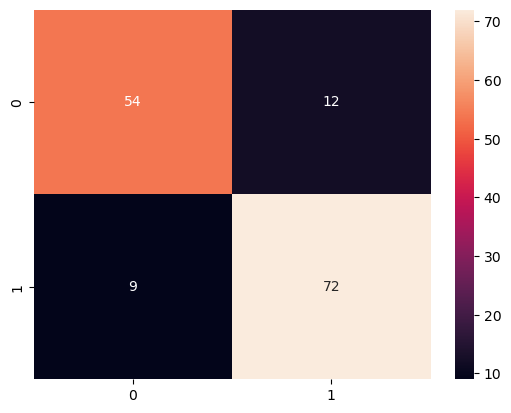

In [64]:
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test set accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [68]:
y_train_pred = best_knn.predict(X_train_selected)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training accuracy : {train_accuracy:.4f}')
print('\nTraining classification report:')
print(classification_report(y_train, y_train_pred))

Training accuracy : 0.8637

Training classification report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       262
           1       0.87      0.89      0.88       325

    accuracy                           0.86       587
   macro avg       0.86      0.86      0.86       587
weighted avg       0.86      0.86      0.86       587



In [70]:
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Difference: {train_accuracy - test_accuracy:.4f}")

Training accuracy: 0.8637
Test accuracy: 0.8571
Difference: 0.0066


The small gap (less than 1%) between training and test accuracy shows that the model generalizes well. It's learned useful patterns without overfitting to the training data.

The high test accuracy (85.71%) confirms that the model handles the classification task effectively. Grid search helped find a good balance, the model is performing well without being too simple or too complex.

Overall, the results suggest that the tuning process worked, we've got a solid model with both strong performance and good generalization.